# 1. Corregir las sugerencias que recibimos de la entrega 2:

    No lematizar

Para esto simplemente omitimos el paso de lematización.

    Tokenización

Este paso lo vamos a pulir, si bien es cierto que al final no estaba mal, vistos los resultados como la cobertura de los modelos de embeddings, se puede mejorar con unos cambios.

Estos eran los resultados previos CON lemmatización y la normalización previa:

In [1]:
""" 
Total de palabras/tokens en todas las conversaciones ORIGINALMENTE: 126935
Total de tokens: 126,935

Vocabulario total: 9,496 palabras/tokens únic@s

Modelo: Word2Vec (Google News)
Palabras encontradas: 4,766/9,496 (50.19%)
Tokens cubiertos: 86,784/126,935 (68.37%)

Top 10 palabras NO encontradas (más frecuentes):
  Doctor:             :  5809 ocurrencias
  Patient:            :  4895 ocurrencias
  to                  :  2077 ocurrencias
  a                   :  1983 ocurrencias
  and                 :  1822 ocurrencias
  of                  :  1567 ocurrencias
  Guest_family:       :   559 ocurrencias
  Yes,                :   518 ocurrencias
  No,                 :   477 ocurrencias
  Yeah,               :   302 ocurrencias

Modelo: GloVe (Wiki Gigaword)
Palabras encontradas: 3,941/9,496 (41.50%)
Tokens cubiertos: 75,535/126,935 (59.51%)

Top 10 palabras NO encontradas (más frecuentes):
  Doctor:             :  5809 ocurrencias
  Patient:            :  4895 ocurrencias
  I                   :  4720 ocurrencias
  Do                  :   648 ocurrencias
  How                 :   581 ocurrencias
  Guest_family:       :   559 ocurrencias
  Yes,                :   518 ocurrencias
  What                :   507 ocurrencias
  No,                 :   477 ocurrencias
  No.                 :   443 ocurrencias

Modelo: FastText (Wiki News)
Palabras encontradas: 5,763/9,496 (60.69%)
Tokens cubiertos: 98,890/126,935 (77.91%)

Top 10 palabras NO encontradas (más frecuentes):
  Doctor:             :  5809 ocurrencias
  Patient:            :  4895 ocurrencias
  Guest_family:       :   559 ocurrencias
  Yes,                :   518 ocurrencias
  No,                 :   477 ocurrencias
  I'm                 :   441 ocurrencias
  don't               :   310 ocurrencias
  Yeah,               :   302 ocurrencias
  Well,               :   256 ocurrencias
  it's                :   249 ocurrencias

TABLA COMPARATIVA DE COBERTURA
                Modelo  Cobertura Vocabulario (%)  Cobertura Tokens (%)  Palabras Encontradas  Palabras No Encontradas
Word2Vec (Google News)                      50.19                 68.37                  4766                     4730
 GloVe (Wiki Gigaword)                      41.50                 59.51                  3941                     5555
  FastText (Wiki News)                      60.69                 77.91                  5763                     3733 """

" \nTotal de palabras/tokens en todas las conversaciones ORIGINALMENTE: 126935\nTotal de tokens: 126,935\n\nVocabulario total: 9,496 palabras/tokens únic@s\n\nModelo: Word2Vec (Google News)\nPalabras encontradas: 4,766/9,496 (50.19%)\nTokens cubiertos: 86,784/126,935 (68.37%)\n\nTop 10 palabras NO encontradas (más frecuentes):\n  Doctor:             :  5809 ocurrencias\n  Patient:            :  4895 ocurrencias\n  to                  :  2077 ocurrencias\n  a                   :  1983 ocurrencias\n  and                 :  1822 ocurrencias\n  of                  :  1567 ocurrencias\n  Guest_family:       :   559 ocurrencias\n  Yes,                :   518 ocurrencias\n  No,                 :   477 ocurrencias\n  Yeah,               :   302 ocurrencias\n\nModelo: GloVe (Wiki Gigaword)\nPalabras encontradas: 3,941/9,496 (41.50%)\nTokens cubiertos: 75,535/126,935 (59.51%)\n\nTop 10 palabras NO encontradas (más frecuentes):\n  Doctor:             :  5809 ocurrencias\n  Patient:            :  

Primero, todos los modelos tienen problemas con las palabras terminando en comas, y palabras abreviadas, por lo que las procesamos:

  yes, -> yes
  
  i'm -> i am

Además, aunque sí haciamos un  Doctor → DOC o Patient → PAT  , el marcador especial cambiaba a minuscula al final, lo arreglaremos.
También hemos encontrado otros tags como Doctor_2, guest_family y guest_clinician. Los trataremos tambien. Esperamos que estos cambios puedan mejorar el trabajo que hacen los 3 modelos.

In [1]:
# Instalación de librerías
%pip install spacy gensim transformers torch tensorflow tensorflow-hub seaborn matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached tf_keras-2.20.1-py3-none-any.whl.metadata (1.8 kB)
Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl (30 kB)
Using cached tf_keras-2.20.1-py3-none-any.whl (1.7 MB)

   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   ---------------------------------------- 0/2 [tf-keras]
   --------

In [2]:
# Imports
import re
import pickle
import unicodedata
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP y embeddings
import spacy
from gensim.models import Word2Vec
import gensim.downloader as api
from transformers import AutoTokenizer, AutoModel

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Deep Learning
import torch
import tensorflow as tf
import tensorflow_hub as hub

C:\Users\Iker\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("../dataset/MTS-Dialog-TrainingSet.csv")

In [4]:
contraction_map = {
    "i'm": "i am",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "that's": "that is",
    "there's": "there is",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "can't": "can not",
    "won't": "will not",
    "couldn't": "could not",
    "wouldn't": "would not",
    "i've": "i have",
    "we're": "we are",
    "they're": "they are",
    "i'll": "i will",
    "i'd": "i would",
    "let's": "let us",
    "what's": "what is",
    "haven't": "have not",
    "ma'am": "madam",
    "how's": "how is",
    "you've": "you have",
    "we'll": "we will",
    "hasn't": "has not",
    "you've": "you have",
    "you'll": "you will",
    "we'll": "we will",
    "hasn't": "has not",
    "how're": "how are",
    "you'd": "you would",
    "we've": "we have",
    "isn't": "is not",
    "wasn't": "was not",
    "it'll": "it will",
    "here's": "here is"
}


def expand_contractions(text):
    text = text.lower()
    for c, repl in contraction_map.items():
        text = re.sub(r"\b" + re.escape(c) + r"\b", repl, text)
    return text

In [5]:
def normalize_text(s, lowercase=True):
    if pd.isna(s):
        return ""

    # Normalizar unicode
    s = unicodedata.normalize("NFKC", str(s))

    # Marcadores de quién habla -> usar tokens temporales
    s = re.sub(r'\bDoctor[:\-]\s*', ' __doc__ ', s, flags=re.I)
    s = re.sub(r'\bDoctor_2[:\-]\s*', ' __doc2__ ', s, flags=re.I)
    s = re.sub(r'\bPatient[:\-]\s*', ' __pat__ ', s, flags=re.I)
    s = re.sub(r'\bGuest_family[:\-]\s*', ' __fam__ ', s, flags=re.I)
    s = re.sub(r'\bGuest_family_1[:\-]\s*', ' __fam__ ', s, flags=re.I) 
    #Si hay dos visitantes, el primero cambia de guest_family a guest_family_1, vamos a igualarlos, esté solo o no siempre será <FAMILY>
    s = re.sub(r'\bGuest_family_2[:\-]\s*', ' __fam2__ ', s, flags=re.I) 
    s = re.sub(r'\bGuest_clinician[:\-]\s*', ' __clin__ ', s, flags=re.I)
    
    # Expand contractions (suponiendo que tienes esta función)
    s = expand_contractions(s)

    # Separar puntuación
    s = re.sub(r'([.,!?;:()"\[\]])', r' \1 ', s)

    # Reducir espacios
    s = re.sub(r'\s+', ' ', s).strip()

    # Lowercase todo excepto los tags
    if lowercase:
        s = s.lower()

    # Restaurar los tags en mayúsculas
    s = s.replace('__doc__', '<DOC>')
    s = s.replace('__doc2__', '<DOC2>')
    s = s.replace('__pat__', '<PAT>')
    s = s.replace('__fam__', '<FAMILY>')
    s = s.replace('__fam2__', '<FAMILY2>')
    s = s.replace('__clin__', '<CLIN>')

    return s
 

# Versión para ELMo (lowercase)
df['dialog_clean'] = df['dialogue'].apply(lambda x: normalize_text(x, lowercase=True))

# Versión para BIO/ClinicalBERT (manteniendo mayúsculas)
df['dialog_clean_clinicBERT'] = df['dialogue'].apply(lambda x: normalize_text(x, lowercase=False))

# Los resúmenes
df['section_text_clean'] = df['section_text'].apply(lambda x: normalize_text(x, lowercase=True))

In [6]:
df['dialog_clean'].head(10)  # primeras 10 filas


0    <DOC> what brings you back into the clinic tod...
1    <DOC> how are you feeling today ? <PAT> terrib...
2    <DOC> hello , miss . what is the reason for yo...
3    <DOC> are you taking any over the counter medi...
4    <DOC> hi , how are you ? <PAT> i burned my han...
5    <DOC> how is your asthma since you started usi...
6    <DOC> do you smoke ? <PAT> no , i quit before ...
7           <DOC> any know drug allergies ? <PAT> no .
8    <DOC> hi there , sir ! how are you today ? <PA...
9    <DOC> can you tell me about any diseases that ...
Name: dialog_clean, dtype: object

In [8]:
# Embeddings (sin lemmatization)
w2v = api.load("word2vec-google-news-300")          # Word2Vec

In [9]:
glove = api.load("glove-wiki-gigaword-300")        # GloVe

In [10]:
ft = api.load("fasttext-wiki-news-subwords-300")   # FastText

In [11]:
# Obtener vocabulario del dataset
all_tokens = []
for text in df['dialog_clean']:
    if pd.notna(text):
        all_tokens.extend(text.split())

vocab = set(all_tokens)
vocab_freq = Counter(all_tokens)

print(f"Total de palabras/tokens: {len(all_tokens):,}")
print(f"\nVocabulario total: {len(vocab):,} palabras/tokens únic@s")


# Análisis para cada modelo
models = {
    'Word2Vec (Google News)': w2v,
    'GloVe (Wiki Gigaword)': glove,
    'FastText (Wiki News)': ft
}

results = []

for model_name, model in models.items():
    print(f"\nModelo: {model_name}")
    
    found_words = [w for w in vocab if w in model.key_to_index]
    missing_words = [w for w in vocab if w not in model.key_to_index]
    
    found_tokens = sum(vocab_freq[w] for w in found_words)
    total_tokens = sum(vocab_freq.values())
    
    coverage_vocab = len(found_words) / len(vocab) * 100
    coverage_tokens = found_tokens / total_tokens * 100
    
    print(f"Palabras encontradas: {len(found_words):,}/{len(vocab):,} ({coverage_vocab:.2f}%)")
    print(f"Tokens cubiertos: {found_tokens:,}/{total_tokens:,} ({coverage_tokens:.2f}%)")
    
    missing_freq = {w: vocab_freq[w] for w in missing_words}
    top_missing = sorted(missing_freq.items(), key=lambda x: x[1], reverse=True)[:10]
    
    print(f"\nTop 10 palabras NO encontradas (más frecuentes):")
    for word, freq in top_missing:
        print(f"  {word:20s}: {freq:5d} ocurrencias")
    
    results.append({
        'Modelo': model_name,
        'Cobertura Vocabulario (%)': round(coverage_vocab, 2),
        'Cobertura Tokens (%)': round(coverage_tokens, 2),
        'Palabras Encontradas': len(found_words),
        'Palabras No Encontradas': len(missing_words)
    })

# Tabla comparativa
print("\nTABLA COMPARATIVA DE COBERTURA")
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

Total de palabras/tokens: 152,151

Vocabulario total: 5,349 palabras/tokens únic@s

Modelo: Word2Vec (Google News)
Palabras encontradas: 5,069/5,349 (94.77%)
Tokens cubiertos: 109,869/152,151 (72.21%)

Top 10 palabras NO encontradas (más frecuentes):
  .                   : 10594 ocurrencias
  ,                   :  6596 ocurrencias
  <DOC>               :  5810 ocurrencias
  ?                   :  5113 ocurrencias
  <PAT>               :  4895 ocurrencias
  a                   :  2121 ocurrencias
  to                  :  2104 ocurrencias
  and                 :  2033 ocurrencias
  of                  :  1654 ocurrencias
  <FAMILY>            :   575 ocurrencias

Modelo: GloVe (Wiki Gigaword)
Palabras encontradas: 5,057/5,349 (94.54%)
Tokens cubiertos: 140,287/152,151 (92.20%)

Top 10 palabras NO encontradas (más frecuentes):
  <DOC>               :  5810 ocurrencias
  <PAT>               :  4895 ocurrencias
  <FAMILY>            :   575 ocurrencias
  <CLIN>              :   119 ocurre

Tras estos cambios, se generan 26,000 tokens más al separar los signos de puntuacion. A cambio, el % de cobertura pasa de 68-69-77% a 72-92-92%. 

Los cambios no han mejorado el Word2Vec tanto como esperabamos, pero por minima que sea, si ha mejrado es que algo hemos hecho bien. Afortunadamente, quitar la lematización y mejorar la normalización han permitido un aumento muy importante en GloVe y FastText. Si nos fijamos, las palabras que no han encontrado son los TAGS, palabras extrañas como lexapro o palabras compuestas como dad's y mom's que no podemos descomponer ya que tienen varios significados ("dad's" puede ser "dad is" o el posesivo de dad). 

### Embeddings Contextuales

En principio solo normalizabamos para los embeddings contextuales y no lematizabamos. Pero ya que también hemos hecho cambios en la normalización, estos cambios les competen y volveremos a correr su código para tener los embeddings actualizados.

    Dos métodos: ELMo y BERT. Para clínico, variantes de Bio/Clinical (BioBERT + ClinicalBERT).

### ELMo

In [ ]:
# Cargar modelo ELMo pre-entrenado desde TensorFlow Hub
print("\nCargando modelo ELMo desde TensorFlow Hub...")
elmo_model = hub.load("https://tfhub.dev/google/elmo/3")
print("Modelo ELMo cargado (dimensión: 1024)")

def get_elmo_embeddings(texts, batch_size=8):
    """
    Extrae embeddings de ELMo para una lista de textos completos.
    ELMo produce embeddings de 1024 dimensiones.
    """
    print(f"\nProcesando {len(texts)} textos con ELMo...")
    
    all_embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Convertir a tensores de TensorFlow
        embeddings = elmo_model.signatures["default"](
            tf.constant(batch_texts)
        )["elmo"]
        
        # Promedio de todos los tokens para obtener vector de secuencia
        sentence_embeddings = tf.reduce_mean(embeddings, axis=1)
        all_embeddings.extend(sentence_embeddings.numpy())
        
        if (i // batch_size + 1) % 10 == 0:
            print(f"  Procesados {min(i+batch_size, len(texts))}/{len(texts)}")
    
    return np.array(all_embeddings)

# Procesar todo el dataset
all_texts = df['dialog_clean'].tolist()

print(f"\nProcesando {len(all_texts)} diálogos (todo el dataset)...")
elmo_embeddings = get_elmo_embeddings(all_texts, batch_size=16)  # batch_size ajustable según RAM

print(f"\nShape de embeddings: {elmo_embeddings.shape}")
print(f"Dimensión por embedding: {elmo_embeddings.shape[1]}")

# Guardar embeddings
embedding_data = {
    'indices': list(range(len(all_texts))),
    'embeddings': elmo_embeddings,
    'shape': elmo_embeddings.shape,
    'model_name': 'ELMo (TensorFlow Hub)',
    'embedding_dim': elmo_embeddings.shape[1]
}

with open('../processed/elmo_embeddings_full.pkl', 'wb') as f:
    pickle.dump(embedding_data, f)

# Guardar también en tsv, para visualizarlo en embedding projector de tensorflow 
np.savetxt("../embedding_projector/elmo_embeddings_tsv.tsv", elmo_embeddings, delimiter="\t")

print(f"\nEmbeddings ELMo guardados en: processed/elmo_embeddings_full.pkl y embedding_projector/elmo_embeddings_tsv")
print(f"  Total de diálogos procesados: {len(all_texts)}")
print(f"  Dimensión: {elmo_embeddings.shape[1]}")

# Añadir referencias al DataFrame
df['has_elmo_embedding'] = True
df['elmo_embedding_idx'] = list(range(len(all_texts)))

print("\nReferencias añadidas al DataFrame para todos los diálogos")

# Ejemplo de similitud para los primeros 5
print("\nEJEMPLO: Similitudes ELMo entre primeros 5 diálogos")
sim_matrix = cosine_similarity(elmo_embeddings[:5])
for i in range(5):
    for j in range(i+1, 5):
        print(f"Diálogo {i} vs Diálogo {j}: similitud = {sim_matrix[i,j]:.4f}")


Cargando modelo ELMo desde TensorFlow Hub...
Modelo ELMo cargado (dimensión: 1024)

Procesando 1201 diálogos (todo el dataset)...

Procesando 1201 textos con ELMo...
  Procesados 160/1201
  Procesados 320/1201
  Procesados 480/1201
  Procesados 640/1201
  Procesados 800/1201
  Procesados 960/1201
  Procesados 1120/1201

Shape de embeddings: (1201, 1024)
Dimensión por embedding: 1024

Embeddings ELMo guardados en: processed/elmo_embeddings_full.pkl y elmo_embeddings_tsv
  Total de diálogos procesados: 1201
  Dimensión: 1024

Referencias añadidas al DataFrame para todos los diálogos

EJEMPLO: Similitudes ELMo entre primeros 5 diálogos
Diálogo 0 vs Diálogo 1: similitud = 0.8343
Diálogo 0 vs Diálogo 2: similitud = 0.9520
Diálogo 0 vs Diálogo 3: similitud = 0.9009
Diálogo 0 vs Diálogo 4: similitud = 0.8088
Diálogo 1 vs Diálogo 2: similitud = 0.8483
Diálogo 1 vs Diálogo 3: similitud = 0.6911
Diálogo 1 vs Diálogo 4: similitud = 0.5161
Diálogo 2 vs Diálogo 3: similitud = 0.9122
Diálogo 2 vs D

In [ ]:
def get_speaker_mix(text):
    speakers = []
    if "<DOC>" in text: speakers.append("DOC")
    if "<DOC2>" in text: speakers.append("DOC2")
    if "<PAT>" in text: speakers.append("PAT")
    if "<FAMILY>" in text: speakers.append("FAM")
    if "<FAMILY2>" in text: speakers.append("FAM2")
    if "<CLIN>" in text: speakers.append("CLIN")
    return "-".join(speakers) if speakers else "UNKNOWN"

df['speaker_mix'] = df['dialog_clean'].apply(get_speaker_mix)

metadata_df = pd.DataFrame({
    "id": df.index,
    "section_header": df["section_header"].str.lower(),
    "speaker_mix": df["speaker_mix"],
    "text_short": df["dialog_clean"].str.replace("\n", " ").str[:120],
    "summary_short": df["section_text_clean"].str.replace("\n", " ").str[:120]
})

metadata_df.to_csv("../embedding_projector/elmo_metadata.tsv", sep="\t", index=False)
print("\nMetadata guardada en: embedding_projector/elmo_metadata.tsv")


Metadata guardada en: processed/elmo_metadata.tsv


### BERT / BIO/ClinicalBERT (huggingface)

In [ ]:
def get_bert_embeddings(texts, model_name, max_length=512, batch_size=8):
    """
    Extrae embeddings de BERT para todos los textos.
    Usa el token [CLS] como representación de la secuencia completa.
    """
    print(f"\nCargando modelo: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        
        encoded = {k: v.to(device) for k, v in encoded.items()}
        
        with torch.no_grad():
            outputs = model(**encoded)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.extend(cls_embeddings)
        
        if (i // batch_size + 1) % 10 == 0:
            print(f"  Procesados {min(i+batch_size, len(texts))}/{len(texts)}")
    
    return np.array(embeddings)

# Modelo BioClinicalBERT preentrenado en textos clínicos
selected_model = 'emilyalsentzer/Bio_ClinicalBERT'

# Procesar TODO el dataset
all_texts_bert = df['dialog_clean_clinicBERT'].tolist()

print(f"\nProcesando {len(all_texts_bert)} diálogos con BioClinicalBERT...")
bert_embeddings = get_bert_embeddings(all_texts_bert, selected_model, batch_size=8)

print(f"\nShape de embeddings: {bert_embeddings.shape}")
print(f"Dimensión por embedding: {bert_embeddings.shape[1]}")

# Guardar embeddings en pickle
embedding_data = {
    'indices': list(range(len(all_texts_bert))),
    'embeddings': bert_embeddings,
    'shape': bert_embeddings.shape,
    'model_name': selected_model,
    'embedding_dim': bert_embeddings.shape[1]}

with open('../processed/clinical_bert_embeddings_full.pkl', 'wb') as f:
    pickle.dump(embedding_data, f)

# Guardar también en tsv, para visualizarlo en embedding projector de tensorflow 
np.savetxt("../embedding_projector/clinical_bert_embeddings_tsv.tsv", bert_embeddings, delimiter="\t")

print(f"\nEmbeddings BioClinicalBERT guardados en: processed/clinical_bert_embeddings_full y embedding_projector/clinical_bert_embeddings_tsv")

# Añadir referencias al DataFrame
df['has_bert_embedding'] = True
df['bert_embedding_idx'] = list(range(len(all_texts_bert)))

print("\nReferencias añadidas al DataFrame para todos los diálogos")

# Ejemplo de similitud para los primeros 5
print("\nEJEMPLO: Similitudes entre primeros 5 diálogos")
sim_matrix = cosine_similarity(bert_embeddings[:5])
for i in range(5):
    for j in range(i+1, 5):
        print(f"Diálogo {i} vs Diálogo {j}: similitud = {sim_matrix[i,j]:.4f}")


Procesando 1201 diálogos con BioClinicalBERT...

Cargando modelo: emilyalsentzer/Bio_ClinicalBERT
  Procesados 80/1201
  Procesados 160/1201
  Procesados 240/1201
  Procesados 320/1201
  Procesados 400/1201
  Procesados 480/1201
  Procesados 560/1201
  Procesados 640/1201
  Procesados 720/1201
  Procesados 800/1201
  Procesados 880/1201
  Procesados 960/1201
  Procesados 1040/1201
  Procesados 1120/1201
  Procesados 1200/1201

Shape de embeddings: (1201, 768)
Dimensión por embedding: 768

Embeddings BioClinicalBERT guardados en: processed/clinical_bert_embeddings_full y processed/embeddings_tsv

Referencias añadidas al DataFrame para todos los diálogos

EJEMPLO: Similitudes entre primeros 5 diálogos
Diálogo 0 vs Diálogo 1: similitud = 0.8885
Diálogo 0 vs Diálogo 2: similitud = 0.9338
Diálogo 0 vs Diálogo 3: similitud = 0.8856
Diálogo 0 vs Diálogo 4: similitud = 0.8332
Diálogo 1 vs Diálogo 2: similitud = 0.9424
Diálogo 1 vs Diálogo 3: similitud = 0.9173
Diálogo 1 vs Diálogo 4: similitu

In [ ]:
metadata_df_bert = pd.DataFrame({
    "id": df.index,
    "section_header": df["section_header"].str.lower(),
    "speaker_mix": df["speaker_mix"],
    "text_short": df["dialog_clean_clinicBERT"].str.replace("\n", " ").str[:120],
    "summary_short": df["section_text_clean"].str.replace("\n", " ").str[:120]
})

metadata_df_bert.to_csv("../embedding_projector/clinical_bert_metadata.tsv", sep="\t", index=False)

print("\nMetadata guardada en: embedding_projector/clinical_bert_metadata.tsv")


Metadata guardada en: processed/clinical_bert_metadata.tsv


Hemos guardado los embeddings en formato pickle y tsv. 

Para visualizarlos, si runneas "tensorboard --logdir embedding_projector", y abres http://localhost:6006, puedes visualizar los embeddings contextuales (puede tardar un poco en cargar).

Visualización  de ELMo

PCA (Principal Component Analysis) y (T-SNE) t-Distributed Stochastic Neighbor Embedding

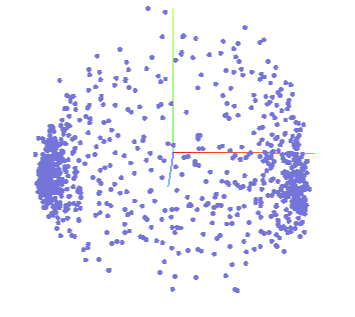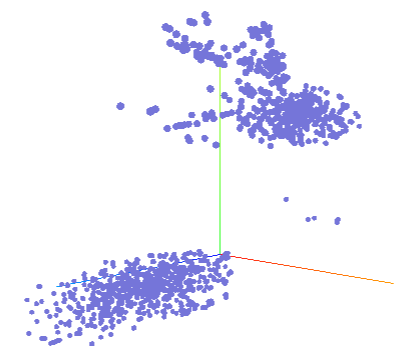

Visualización de Clinical BERT

PCA (Principal Component Analysis) y (T-SNE) t-Distributed Stochastic Neighbor Embedding

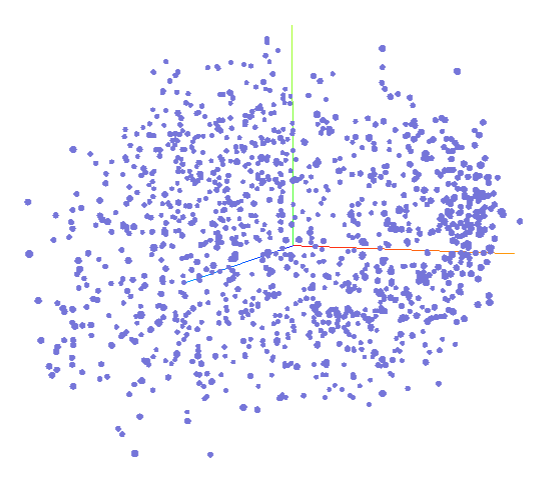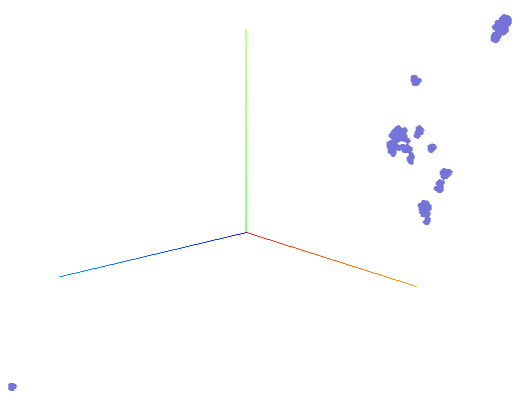

En ambos modelos, PCA tiende a mostrar una distribución más uniforme frente a t-SNE que muestra agrupaciones más claras.

Especialmente en el t-SNE del Clinical-BERT que parece ser capaz de hacer agrupaciones bastante definidas. Esto puede sugerir que Clinical-BERT logra identificar similitudes en las conversaciones clínicas. 